Distribuzione Ampia: Saturazione distribuita


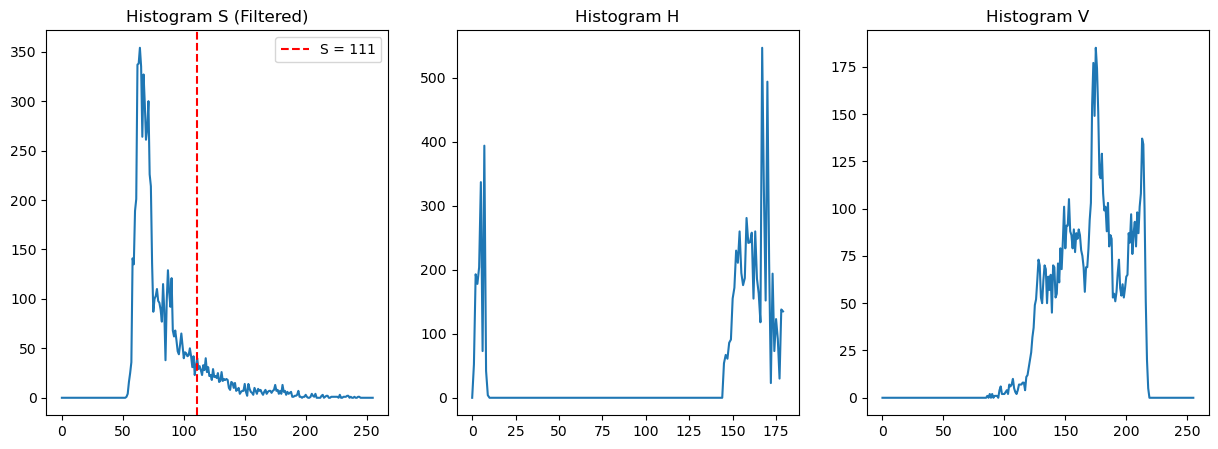

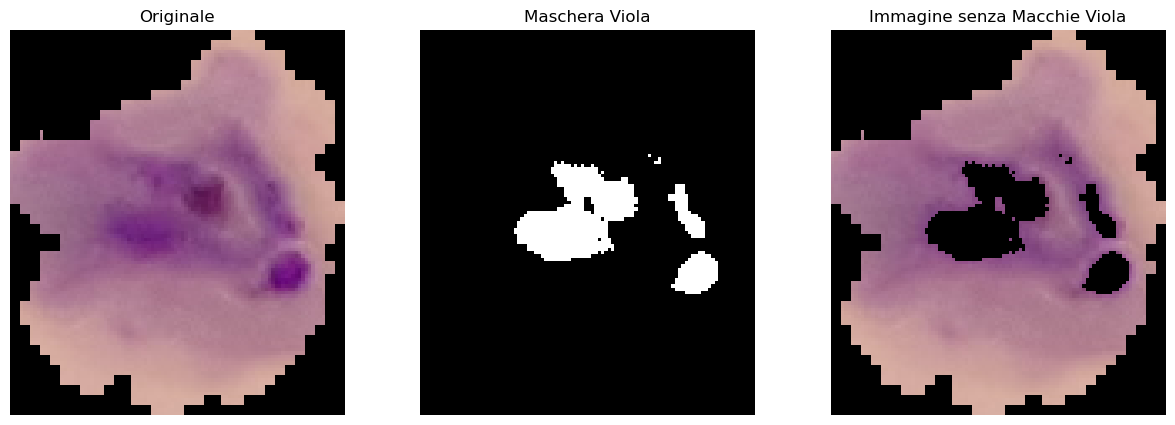

In [8]:
import cv2
import os #La utilizzo per effettuare una run su tutte le immagini della cartella
import numpy as np
import matplotlib.pyplot as plt

# Carica l'immagine
image = cv2.imread('FESI/Progetto/malaria/malaria/parasite (26).png')  # Sostituisci con il percorso dell'immagine
original = image.copy()

# Converti l'immagine nello spazio colore HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Creo delle maschere per filtrare lo sfondo
non_zero_saturation = hsv[:, :, 1] > 0  
non_zero_hue = hsv[:, :, 0] > 0  
non_zero_value = hsv[:, :, 2]> 0

# Filtra i pixel di saturazione > 0
filtered_saturation = hsv[:, :, 1][non_zero_saturation]
filtered_hue = hsv[:, :, 0][non_zero_hue]
filtered_value = hsv[:, :, 2][non_zero_value]

# Calcola gli istogrammi
hist_h = cv2.calcHist([filtered_hue], [0], None, [180], [0, 180])
hist_s_filtered = cv2.calcHist([filtered_saturation], [0], None, [256], [0, 256])
hist_v = cv2.calcHist([filtered_value], [0], None, [256], [0, 256])

# Calcola metriche per l'analisi della distribuzione
filtered_saturation_mean = np.mean(filtered_saturation[filtered_saturation > 0])  # Saturazione media (escludendo sfondo)
filtered_saturation_std = np.std(filtered_saturation[filtered_saturation > 0])    # Deviazione standard
filtered_saturation_mode = np.argmax(hist_s_filtered)                   # Moda (valore più frequente)

# Condizioni basate sull'analisi della distribuzione
if filtered_saturation_std < 20:  # Distribuzione stretta
    print("Distribuzione Stretta: Saturazione concentrata")
    saturation_threshold_max = min(255, filtered_saturation_mode + 20)
else:  # Distribuzione ampia
    print("Distribuzione Ampia: Saturazione distribuita")
    saturation_threshold_max = min(255, int(filtered_saturation_mean + filtered_saturation_std))


# Visualizza l'istogramma della saturazione e la soglia s_min
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1), plt.plot(hist_s_filtered), plt.title('Histogram S (Filtered)')
plt.axvline(saturation_threshold_max, color='r', linestyle='--', label=f'S = {saturation_threshold_max}')
plt.legend()
plt.subplot(1, 3, 2), plt.plot(hist_h), plt.title('Histogram H')
plt.subplot(1, 3, 3), plt.plot(hist_v), plt.title('Histogram V')
plt.show()

lower_purple = np.array([120, (saturation_threshold_max + 8 ), 70])  # Limite inferiore (Hue, Saturation, Value)
upper_purple = np.array([185, 255, 255])  # Limite superiore

# Crea una maschera per isolare le aree viola
mask = cv2.inRange(hsv, lower_purple, upper_purple)

# Rimuovi le macchie viola dall'immagine
image[mask > 0] = [0, 0, 0]  # Sostituisce il viola con nero

# Visualizza i risultati
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axs[0].set_title('Originale')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Maschera Viola')
axs[2].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[2].set_title('Immagine senza Macchie Viola')
for ax in axs:
    ax.axis('off')
plt.show()



Visto che in alcune immagini (come la 13, inserisci il link) il valore di saturazione scelto causava un eccessiva rimozione della cellula. Il valore di saturazione scelto oscillava tra quelli più utilizzati (inserisci immagine con punto sull'istogramma), e non uno di quelli con frequenza minore, osservando questo istogramma a noi interessa un valore che stia più o meno tra i 125 (inserisci poi foto dell'istogramma e tutto).
Nelle immagini come la 54 dove l'istogramma di Hue è formato da 2 grandi picchi come valori, e la saturazione è invece un grande picco che si alza e poi si abbassa, il valore di saturazione sufficiente è s. Mettere prima i risultati "sbagliati" e poi quelli giusti. Vedi file .txt nell'altra cartella progetto. <br>
Sfrutto quindi un analisi dei due istogrammi (Hue e Saturation) per aggirare il problema 

### Visualizzazione istogramma 2d Per mettere in relazione Tonalità e saturazione (da vedere se sfruttabile)